In [38]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')
!sudo apt-get -q update > /dev/null && sudo apt-get -q install -y tesseract-ocr-rus > /dev/null
!pip install -q pytesseract
%env PROJ_PATH=/content/drive/MyDrive/Colab_Notebooks/manuscript

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
env: PROJ_PATH=/content/drive/MyDrive/Colab_Notebooks/manuscript


In [39]:
#libraries
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from google.colab.patches import cv2_imshow

In [40]:
#paths
PATH = '/content/drive/MyDrive/Colab_Notebooks/manuscript/'
output_path = '/content/drive/'
image_path = '/content/drive/MyDrive/Colab_Notebooks/manuscript/test.png'
output_path = 'boxes.png'
index_to_char = {
    0: '!',  1: ',',  2: '-',  3: '.',  4: ':',  5: ';',  6: '?',  7: 'Ё',  8: 'Ў',  9: 'А',
    10: 'Б', 11: 'В', 12: 'Г', 13: 'Д', 14: 'Е', 15: 'Ж', 16: 'З', 17: 'И', 18: 'Й', 19: 'К',
    20: 'Л', 21: 'М', 22: 'Н', 23: 'О', 24: 'п', 25: 'р', 26: 'с', 27: 'т', 28: 'у', 29: 'Ф',
    30: 'Х', 31: 'Ч', 32: 'Ш', 33: 'Э', 34: 'Ю', 35: 'Я', 36: 'а', 37: 'б', 38: 'в', 39: 'г',
    40: 'д', 41: 'е', 42: 'ж', 43: 'з', 44: 'и', 45: 'й', 46: 'к', 47: 'л', 48: 'м', 49: 'н',
    50: 'о', 51: 'П', 52: 'Р', 53: 'С', 54: 'Т', 55: 'у', 56: 'ф', 57: 'х', 58: 'ч', 59: 'ш',
    60: 'э', 61: 'ю', 62: 'я', 63: 'ё', 64: 'ў', 65: 'Ғ', 66: 'ғ', 67: 'Қ', 68: 'қ', 69: 'Ҳ',
    70: 'ҳ', 71: '—', 72: '”', 73: '„',
}

In [41]:
#functions
def display_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


class modelCNN(nn.Module):
    def __init__(self, num_classes=74):
        super(modelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


def draw_bounding_boxes(image_path, data, output_path):
    image = cv2.imread(image_path)
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:
            top_left = [data['left'][i], data['top'][i]]
            w, h = data['width'][i], data['height'][i]
            top_left_x, top_left_y = top_left
            bottom_right_x = top_left_x + w
            bottom_right_y = top_left_y + h
            cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 0, 255), 2)
    cv2.imwrite(output_path, image)


def recognize_text_in_box(image, top_left, width, height):
    cropped_img = image[top_left[1]:top_left[1]+height, top_left[0]:top_left[0]+width]
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    symbols = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        symbol_img = cropped_img[y:y+h, x:x+w]
        resized_symbol = cv2.resize(symbol_img, (28, 28))
        symbol_img_pil = Image.fromarray(resized_symbol)
        symbol_img_pil = transform(symbol_img_pil)
        symbol_img_pil = symbol_img_pil.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(symbol_img_pil)
        predicted_index = torch.argmax(output, dim=1).item()
        symbol = index_to_char.get(predicted_index, '?')
        symbols.append(symbol)
    return ''.join(symbols)


def draw_bounding_boxes_and_recognize(image_path, data, output_path):
    image = cv2.imread(image_path)
    all_text = []

    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:
            top_left = [data['left'][i], data['top'][i]]
            w, h = data['width'][i], data['height'][i]

            top_left_x, top_left_y = top_left
            bottom_right_x = top_left_x + w
            bottom_right_y = top_left_y + h
            cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 0, 255), 2)

            recognized_text = recognize_text_in_box(image, top_left, w, h)
            all_text.append(recognized_text)
    cv2.imwrite(output_path, image)
    return ' '.join(all_text)


def clean_text_in_boxes(image_path, data, output_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    draw = ImageDraw.Draw(pil_image)

    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)

    for i in range(len(data['text'])):
        pos_y = data['line_num'][i]
        word = data['text'][i]
        if word != "":
            top_left = (data['left'][i], data['top'][i])
            bottom_right = (data['left'][i] + data['width'][i], data['top'][i] + data['height'][i])

            word_bbox = draw.textbbox((0, 0), word, font=font)
            word_width, word_height = word_bbox[2] - word_bbox[0], word_bbox[3] - word_bbox[1]
            draw.rectangle([top_left, bottom_right], fill=(255, 255, 255))

            #y_offset = top_left[1]
            #draw.text((top_left[0], y_offset), word, font=font, fill=(0, 0, 139))

    pil_image = pil_image.convert("RGB")
    pil_image.save(output_path)


def add_text_to_image(image_path, text_data, output_image_path, font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", font_size=24):
    image = cv2.imread(image_path)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    font = ImageFont.truetype(font_path, font_size)

    text = []
    for word in range(len(text_data['text'])):
        if text_data['text'][word] != "":
            text.append(text_data['text'][word])

    x, y = 20, 20
    color = (0, 0, 139)
    max_width = image_pil.width - 40
    line = ""

    for word in text:
        test_line = line + word + " "
        bbox = draw.textbbox((x, y), test_line, font=font)
        text_width = bbox[2] - bbox[0]

        if text_width <= max_width:
            line = test_line
        else:
            draw.text((x, y), line, font=font, fill=color)
            bbox = draw.textbbox((x, y), line, font=font)
            y += bbox[3] - bbox[1]
            line = word + " "

    if line:
        draw.text((x, y), line, font=font, fill=color)
    image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, image)
    return output_image_path

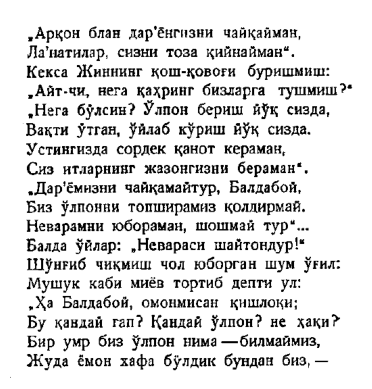

In [42]:
display_image(image_path)

In [43]:
!cd /content/ && python $PROJ_PATH/text_recognition.py --east $PROJ_PATH/frozen_east_text_detection.pb --image $PROJ_PATH/test.png --cmd /usr/bin/tesseract

[INFO] loading the detector...
[INFO] detection in 1.21 seconds


In [44]:
img = Image.open(image_path)
data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang='rus')

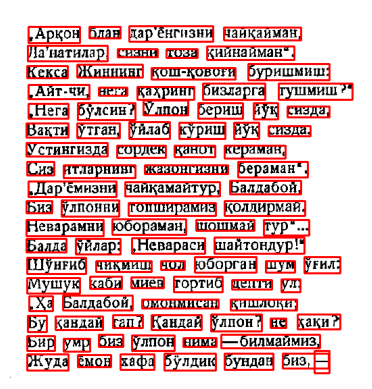

In [45]:
boxes = []
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 0:
        top_left = [data['left'][i], data['top'][i]]
        w, h = data['width'][i], data['height'][i]
        draw_bounding_boxes(image_path, data, output_path)
        boxes.append((data['top'][i], data['left'][i], data['width'][i], data['height'][i]))
display_image('boxes.png')

In [10]:
model = modelCNN(num_classes=74)
model.load_state_dict(torch.load(f'{PATH}recognition_chars_weights.pth', weights_only=True), strict=False)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

recognized_text = draw_bounding_boxes_and_recognize(image_path, data, output_path)
print('Recognized Text:', recognized_text)

Recognized Text: Ж Ш Ш Ж Ж Л Ш Ш Ш ф Ж Ж Ж Ю Ж Ж Ж Ж Ж Ш Ж Ю Ш Ш Ш Ж Ш Ш Л Ж Ж Ж Ж Ш Ю Л Ж Ж Ж Ж Ш Ю Ж Ж Ж Ж Ф Ю Ш Ж Ж Ж Ж Ш Ш Ж Ш Ж Ж Ш Ш Ж Л Ш Л Ж Л Ж Ш Ж Ж Ж Ж ш Ж Ш Ю Ш Ж Ш Ж Ш Ш Ж Ю Ж Ю ”


In [46]:
clean_text_in_boxes(image_path, data, 'clean.png')
add_text_to_image('clean.png', data, 'image_with_text.png')

'image_with_text.png'